# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Parameters

In [1]:
TRAIN_DIR = 'model5/'
SEED = 7
USE_JITTERED = True
N_TRANSFORMS = 6
BATCH_SIZE = 128
IMPROVEMENT_THRESHOLD = 0.995
PATIENCE = 15
EPOCHS = 200

IMAGE_SIZE = [32,32,3]
NUM_CLASSES = 43

LEARNING_RATE = 1e-3
KEEP_PROP = 0.5

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
# Load pickled data
import pickle
import os

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
#Summmary
n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
%matplotlib inline

In [5]:
#Load class names for visualization
signnames = []
with open('signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

In [6]:
#Function to plot images in a grid with their corresponding class id and name
def plot_signs(images, labels=None, rows=2, cols=4, rnd=True):

    nimg = min(len(images),rows*cols)
    if rnd:
        selection = np.random.choice(images.shape[0], nimg, replace=False)
    else:
        selection = range(nimg)
        
    images_to_show = images[selection]
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            if index >= len(images_to_show):
                break
                
            ax = axarr[row,col] if rows > 1 else axarr[col]
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels is not None:
                label_id = labels[selection][index]
                ax.set_title('%s - %s' % (label_id, signnames[label_id]), fontsize=8)

## Training Set Visualization

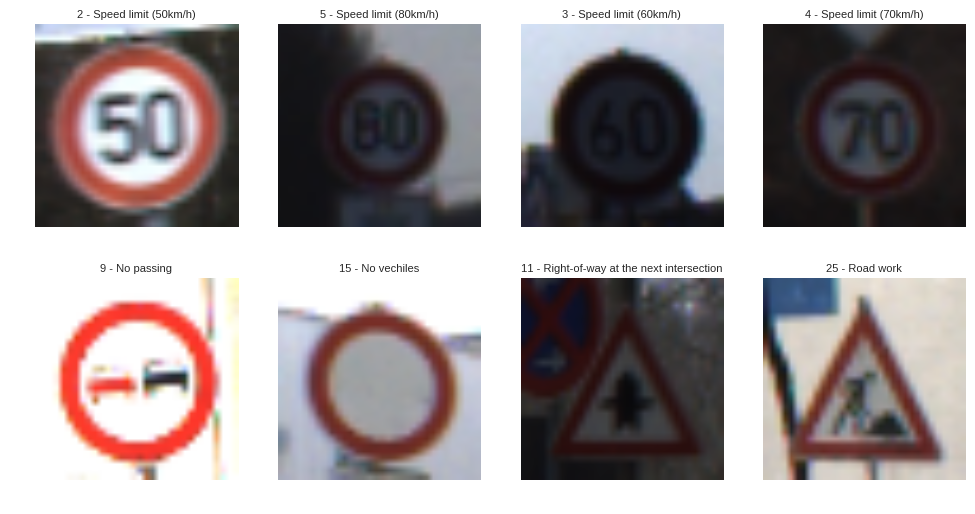

In [7]:
plot_signs(X_train, y_train)

## Test Set Visualization

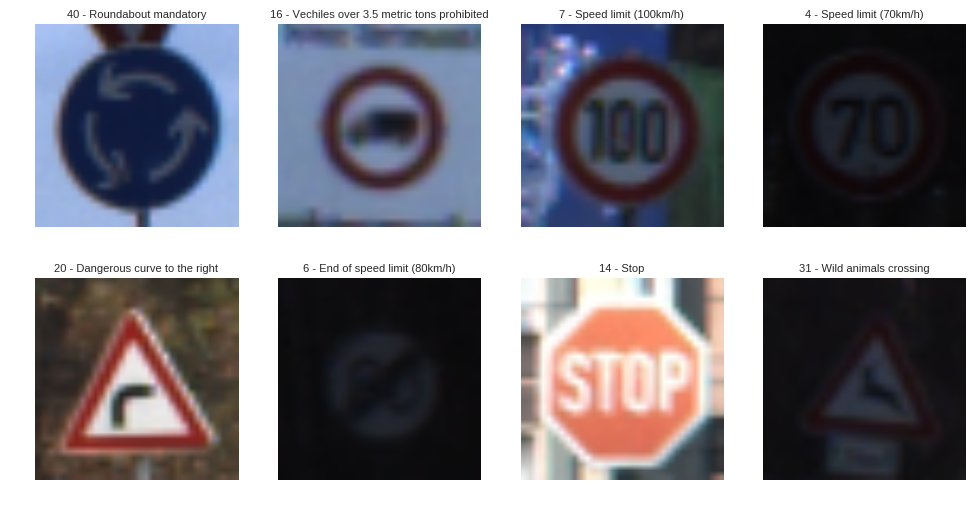

In [8]:
plot_signs(X_test, y_test)

### Class distribution

In [9]:
from collections import Counter
train_label_counter = Counter(y_train)

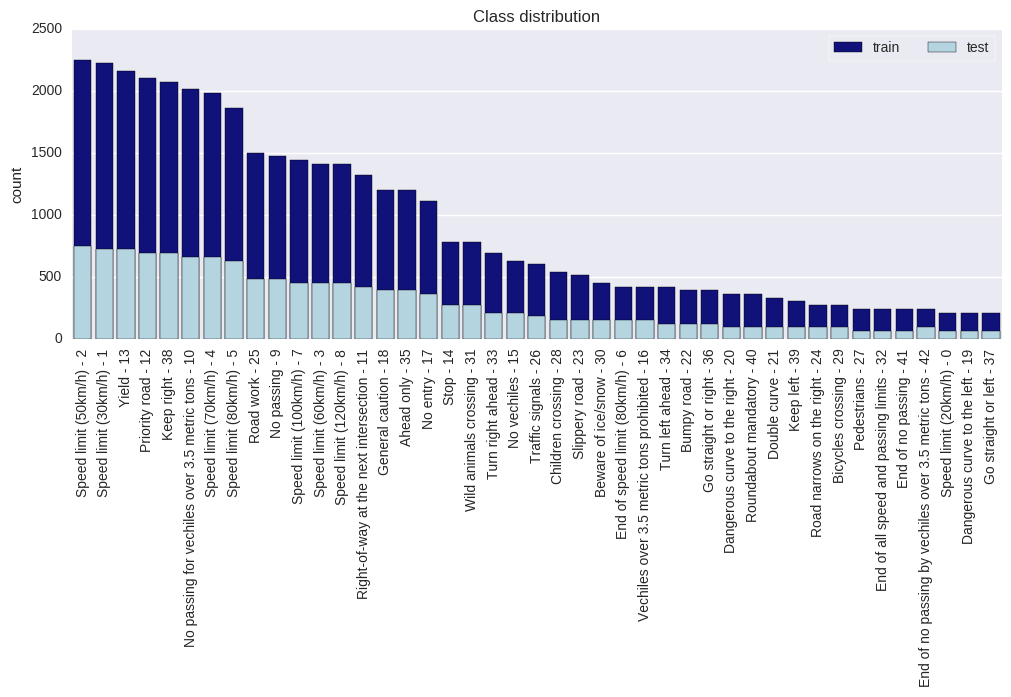

In [10]:
train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x=y_train, order=order, color='darkblue', ax=ax, label="train")

ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The final version does only normalize images to values between 0 and 1. However the model does a color space transformation on it's own using a technique described in [<a href="https://arxiv.org/abs/1606.02228">1</a>]. There were also experiments done with only gray scale images and/or feature wise z-transformed values which didn't end up improving the accuracy.

More preprocessing is done for additional generated data using Keras ImageDataGenerator. It adds random transformation like rotation, zooming and color channel shift to the initial training data. To train the final model five augmented versions for each image is used in addition to the initial data.

In addition to the processing done to the features, the labels have been one hot encoded.

# Preprocessing

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm_notebook, tnrange

Using TensorFlow backend.


In [12]:
#Function to normalize images to a given value range
def normalize(images, newMax=1., newMin=0., oldMax=255, oldMin=0):
    return (images - oldMin) * ((newMax - newMin)/(oldMax - oldMin)) + newMin

In [13]:
# wrapper function which uses keras ImageDataGenerator to generate and add augmented images to a given dataset
def add_augumented_data(x, y, nb_transforms, rotation = 30, trans_range = 0.3, channel_shift = 0.05):
    datagen = ImageDataGenerator(rotation_range=rotation,                           
                                 channel_shift_range=channel_shift,
                                 shear_range=trans_range,
                                 zoom_range=trans_range,
                                 width_shift_range=trans_range,
                                 height_shift_range=trans_range,
                                 fill_mode='nearest')

    datagen.fit(x, seed=SEED)
    batch_size = x.shape[0]

    for i in tnrange(nb_transforms, desc='Jittering'):       
        X_batch, y_batch = next(datagen.flow(x, y, batch_size=batch_size, seed=SEED))

        x = np.concatenate((x, X_batch), axis=0)
        y = np.concatenate((y, y_batch), axis=0)
        
    return x,y

In [14]:
#One hot encoding
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))

def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls

In [15]:
#normalize features so that all values are between 0 and 1
X_train = normalize(X_train).astype(np.float32)
X_test = normalize(X_test).astype(np.float32)

In [16]:
# Split train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=SEED)

In [17]:
#Add Augumented data to the training set
X_train, y_train = add_augumented_data(X_train, y_train, N_TRANSFORMS)

In [18]:
#Shuffel train and validation set
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)
X_val, y_val = shuffle(X_val, y_val, random_state=SEED)

In [19]:
#Encode labels
y_train, y_train_cls = one_hot_encoding(y_train, lb)
y_val, y_val_cls = one_hot_encoding(y_val, lb)
y_test, y_test_cls = one_hot_encoding(y_test, lb)

In [20]:
#make sure features are of type float32 not float64
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [21]:
print("Number of training features =", X_train.shape[0])
print("Number of validation features =", X_val.shape[0])
print("Number of test features =", X_test.shape[0])

Number of training features = 192122
Number of validation features = 11763
Number of test features = 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The given test data was not touched at all except for the normalization. For the train data, additional augmented images were generated to improve generalization of the model. In the beginning only the given data was used which already yielded results around 95% test accuracy. To get even further the complexity of the model was increased and augmented data added.

To generate a validation set the train data was split using sklearns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">train_test_split</a> allowing to keep the same distribution in both datasets. The validation set size was chosen to be 30% of the total initial training data.

# Architecture

In [22]:
import tensorflow as tf
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import stats

## Helper

In [23]:
def _activation_summary(x):
    tensor_name = x.op.name
    tf.histogram_summary(tensor_name + '/activations', x)
    tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

def create_weights(shape, mean=0.0, stddev=0.2, wd=None):
    weight = tf.Variable(tf.truncated_normal(shape, mean=mean, stddev=stddev, dtype=tf.float32), name='weights')
    
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(weight), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
        
    return weight


def create_biases(length, value=0.0):
    bias = tf.Variable(tf.fill([length], value), dtype=tf.float32, name='biases')
    return bias


def create_conv_layer(input,
                      num_filters,
                      filter_size=[1,1],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      batch_norm=False,
                      is_training=False,
                      wd=None):

    num_input_channels = int(input.get_shape()[3]) 
    shape = [filter_size[0], filter_size[1], num_input_channels, num_filters]

    weights = create_weights(shape=shape, wd=wd)
    conv = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=strides,
                         padding=padding,
                         name='Convolution')

    if batch_norm:
        conv = tf.contrib.layers.batch_norm(conv, scale=True, updates_collections=None, is_training=is_training)
    else:
        biases = create_biases(length=num_filters)
        conv = tf.nn.bias_add(conv, biases)
    
    if relu == True:
        conv = tf.nn.relu(conv)
        
    _activation_summary(conv)
    
    return conv


def create_fc_layer(input,
                    num_inputs,
                    num_outputs,
                    relu=True,
                    batch_norm=False,
                    is_training=False,
                    wd=None):

    weights = create_weights(shape=[num_inputs, num_outputs], wd=wd)
    fc = tf.matmul(input, weights, name='Fully_Connected')
    
    if batch_norm:
        fc = tf.contrib.layers.batch_norm(fc, scale=True, updates_collections=None, is_training=is_training)
    else:
        biases = create_biases(length=num_outputs)
        fc = tf.nn.bias_add(fc, biases)
    
    if relu == True:
        fc = tf.nn.relu(fc)

    _activation_summary(fc)
        
    return fc

def pool_max_avg_sum(input,
                     ksize=[1, 3, 3, 1], 
                     strides=[1, 2, 2, 1],
                     padding='SAME',
                     name=''):
    
    pool_max = tf.nn.max_pool(input,
                       ksize=ksize, 
                       strides=strides,
                       padding=padding,
                       name='max_pool')

    pool_avg = tf.nn.avg_pool(input,
                           ksize=ksize, 
                           strides=strides,
                           padding=padding,
                           name='avg_pool')
    
    return tf.add(pool_max, pool_avg, name=name)
    

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features], name='flatten')
    return layer_flat, num_features

## Model

In [24]:
def inference(images, keep_prop, is_training):
    
    tf.image_summary('images_raw', images)
        
    with tf.name_scope("color_space"):
        cs = create_conv_layer(images,
                               num_filters=10,
                               filter_size=[1,1],
                               relu=False,
                               batch_norm=True,
                               is_training=is_training)
        cs = create_conv_layer(cs,
                               num_filters=3,
                               filter_size=[1,1],
                               relu=False,
                               batch_norm=True,
                               is_training=is_training)
        tf.image_summary('images_color_space', cs)
    
    with tf.name_scope("conv1"):
        conv1 = create_conv_layer(cs,
                                  num_filters=64,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)
        
        conv1 = create_conv_layer(conv1,
                                  num_filters=64,
                                  filter_size=[5,5],
                                  batch_norm=True,
                                  is_training=is_training)
        conv1 = create_conv_layer(conv1,
                                  num_filters=128,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)        
    pool1 = pool_max_avg_sum(conv1, name='pool1')
    dropout1 = tf.nn.dropout(pool1, keep_prob=keep_prop, name='Dropout1', seed=SEED)

    with tf.name_scope("conv2"):
        conv2 = create_conv_layer(dropout1,
                                  num_filters=128,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)
        conv2 = create_conv_layer(conv2,
                                  num_filters=128,
                                  filter_size=[5,5],
                                  batch_norm=True,
                                  is_training=is_training)
        conv2 = create_conv_layer(conv2,
                                  num_filters=256,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)        
    pool2 = pool_max_avg_sum(conv2, name='pool2')
    dropout2 = tf.nn.dropout(pool2, keep_prob=keep_prop, name='Dropout2', seed=SEED)

    with tf.name_scope("conv3"):
        conv3 = create_conv_layer(dropout2,
                                  num_filters=128,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)
        conv3 = create_conv_layer(conv3,
                                  num_filters=128,
                                  filter_size=[3,3],
                                  batch_norm=True,
                                  is_training=is_training)
        conv3 = create_conv_layer(conv3,
                                  num_filters=256,
                                  filter_size=[1,1],
                                  batch_norm=True,
                                  is_training=is_training)

    pool3 = pool_max_avg_sum(conv3, name='pool3')

    flatten, num_features = flatten_layer(pool3)

    dropout3 = tf.nn.dropout(flatten, keep_prob=keep_prop, name='Dropout3', seed=SEED)

    with tf.name_scope("fc1"):
        fc1 = create_fc_layer(dropout3,
                              num_inputs=num_features,
                              num_outputs=num_features,
                              wd=0.1)

    with tf.name_scope("softmax_linear"):
        softmax_linear = create_fc_layer(fc1,
                                         num_inputs=num_features,
                                         num_outputs=NUM_CLASSES,
                                         relu=False)

    return softmax_linear

In [25]:
def get_loss(logits, labels, l2=True):
    with tf.name_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
          logits, labels, name='cross_entropy_per_example')

        cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
        tf.add_to_collection('losses', cross_entropy_mean)

        loss = tf.add_n(tf.get_collection('losses'), name='total_loss') if l2 else cross_entropy_mean
    
    return loss

In [26]:
def get_accuracy(logits, labels_cls):
    with tf.name_scope("evaluation"):
        pred = tf.nn.softmax(logits)
        pred_cls = tf.argmax(pred, dimension=1)
        correct_prediction = tf.equal(pred_cls, labels_cls)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**


| Stage              | type   |stride | size | filter/feature |
|--------------------|--------|-------|------|----------------|
| Color space        | conv   |  1x1  |  1x1 |      10        |
|                    | conv   |  1x1  |  1x1 |       3        |
| Conv Stage 1       | conv   |  1x1  |  1x1 |      64        |
|                    | conv   |  1x1  |  5x5 |      64        |
|                    | conv   |  1x1  |  1x1 |     128        |
| Max + Avg          | pool   |  2x2  |  3x3 |                |
| Dropout                                                     |
| Conv Stage 2       | conv   |  1x1  |  1x1 |     128        |
|                    | conv   |  1x1  |  5x5 |     128        |
|                    | conv   |  1x1  |  1x1 |     256        |
| Max + Avg          | pool   |  2x2  |  3x3 |                |
| Dropout                                                     |
| Conv Stage 3       | conv   |  1x1  |  1x1 |     128        |
|                    | conv   |  1x1  |  3x3 |     128        |
|                    | conv   |  1x1  |  1x1 |     256        |
| Max + Avg          | pool   |  2x2  |  3x3 |                |
| Flatten                                                     |
| Dropout                                                     |
| Fully connected    |        |       |      |       4096     |
| Softmax            |        |       |      |       43       |

## Helper

In [27]:
def update_performance_plot(fig, ax, x_vals, y_vals):
    for y, line in zip(y_vals, ax.lines):
        line.set_xdata(x_vals)
        line.set_ydata(y)
        
    if len(x_vals) > 0 and x_vals[-1] > ax.get_xlim()[1] - 100:
        ax.set_xlim(0, ax.get_xlim()[1] + 1000)
    
    fig.canvas.draw()
    
def init_performance_plot(labels, colors):
    figsize = (12, 4)
    fig, ax = plt.subplots(figsize=figsize)
    num_ticks = 6
    ax.set_title('Performance')
    ax.set_ylim([0, 1.0])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('batches')
    
    [ax.plot([],[], color=c, label=l) for l, c in zip(labels, colors)]  
    ax.legend(loc=5)
    
    return (fig, ax)

def get_batch(batch_i, X, y):
    batch_start = batch_i*BATCH_SIZE
    batch_end = min([batch_start + BATCH_SIZE, len(X)])
    batch_features = X[batch_start:batch_end]
    batch_labels = y[batch_start:batch_end]
    
    return batch_features, batch_labels

def get_sample(x, y, sample_size):
    sample_size = min(x.shape[0], sample_size)
    i = np.random.choice(x.shape[0], sample_size)

    return x[i], y[i]

def calculate_for_sample(x, y, tf_op, sample_size=1000):
    sample_size = min(x.shape[0], sample_size)
    sample_features, sample_labels = get_sample(x, y, sample_size)

    feed_dict = {features: sample_features, labels: sample_labels, keep_prop:1, is_training:False}
    return session.run(tf_op, feed_dict=feed_dict)

def update_metrics(accuracy, loss, sample_size=1000):
    global valid_loss_batch
    global valid_acc_batch
    global train_loss_batch
    global train_acc_batch
    
    val_loss, val_acc = calculate_for_sample(X_val,
                                             y_val,                      
                                             [loss, accuracy],
                                             sample_size=sample_size)

    valid_loss_batch.append(val_loss)
    valid_acc_batch.append(val_acc)


    train_loss, train_acc = calculate_for_sample(X_train,
                                                 y_train,
                                                 [loss, accuracy],
                                                 sample_size=sample_size)              
    train_loss_batch.append(train_loss)
    train_acc_batch.append(train_acc)

## Training

<IPython.core.display.Javascript object>


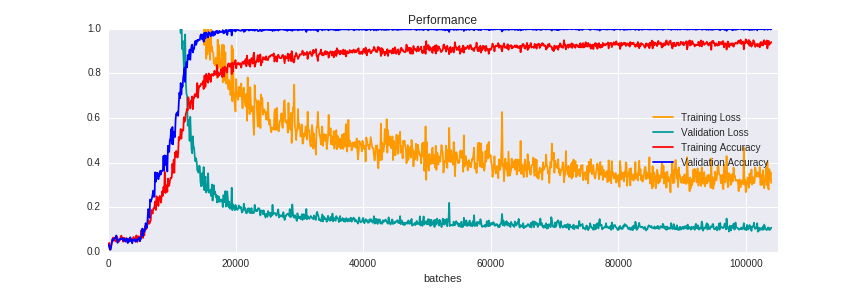

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/patrick/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/patrick/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/patrick/anaconda3/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Best Validation loss: 0.100345


In [39]:
%matplotlib notebook
current_best_loss = np.inf
current_patience = PATIENCE
done_training = False
valid_loss_batch = []
valid_acc_batch = []
train_loss_batch = []
train_acc_batch = []
batches = []
predictions = []
batch_count = int(math.ceil(len(X_train)/BATCH_SIZE))
val_batch_count = int(math.ceil(len(X_val)/BATCH_SIZE))
fig, ax = init_performance_plot(['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'],
                               ['#FF9900', '#009999', '#FF0000', '#0000FF'])


tf.reset_default_graph()
with tf.Graph().as_default():
    with tf.name_scope("variables"):
        features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')
        labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
        labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')
        is_training = tf.placeholder(tf.bool, [], name='is_training')
        keep_prop = tf.placeholder(dtype=tf.float32, name='keep_prop')

                                   
    logits = inference(features, keep_prop, is_training)
    loss = get_loss(logits, labels)
    accuracy = get_accuracy(logits, labels_cls)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss) 

    saver = tf.train.Saver(tf.all_variables())
    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()                                  
       

    # Start running operations on the Graph.
    with tf.Session() as session:
        session.run(init)
        summary_writer = tf.train.SummaryWriter(TRAIN_DIR, session.graph)
                                   
        for epoch_i in range(EPOCHS):
            if done_training:
                break
            
            batches_pbar = tnrange(batch_count,
                                   desc='Epoch %s/%s' % (epoch_i+1, EPOCHS),
                                   unit=' batches ',
                                   leave=False,
                                   smoothing=0.3)

            for batch_i in batches_pbar:
                step = epoch_i * BATCH_SIZE + batch_i
                batch_features, batch_labels = get_batch(batch_i, X_train, y_train)

                feed_dict={features: batch_features,
                           labels: batch_labels,
                           keep_prop:KEEP_PROP,
                           is_training:True}
                
                _ = session.run(optimizer, feed_dict=feed_dict)


                #Log and write summary
                if step % 100 == 0:                                  
                    previous_batch = batches[-1] if batches else 0
                    batches.append(previous_batch + 100)

                    update_metrics(accuracy, loss)
                    update_performance_plot(fig, ax, batches, [train_loss_batch,
                                                               valid_loss_batch,
                                                               train_acc_batch,
                                                               valid_acc_batch])


                    summary_str = session.run(summary_op, feed_dict=feed_dict)
                    summary_writer.add_summary(summary_str, step)
                    
                # Save the model checkpoint periodically.
                if step % 1000 == 0:
                    cur_batch_loss = []
                    for val_batch_i in range(val_batch_count):
                        batch_features, batch_labels = get_batch(val_batch_i, X_val, y_val)

                        feed_dict={features: batch_features,
                                   labels: batch_labels,
                                   keep_prop:1,
                                   is_training:False}

                        cur_batch_loss.append(session.run(loss, feed_dict=feed_dict))
                        
                    current_loss = np.mean(cur_batch_loss)
                    if current_loss < current_best_loss * IMPROVEMENT_THRESHOLD:
                        current_best_loss = current_loss
                        current_patience = PATIENCE
                        checkpoint_path = os.path.join(TRAIN_DIR, 'model.ckpt')
                        saver.save(session, checkpoint_path, global_step=step)
                    else:
                        current_patience -= 1
                    
                    if current_patience == 0:
                        done_training = True
                        batches_pbar.write('Best Validation loss: %s' % current_best_loss)
                        break
                            
%matplotlib inline

## Test

In [50]:
test_batch_acc = []
batch_count = int(math.ceil(len(X_test)/BATCH_SIZE))

with tf.Graph().as_default():
    with tf.name_scope("variables"):
        features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')
        labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
        labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')
        is_training = tf.placeholder(tf.bool, [], name='is_training')
        keep_prop = tf.placeholder(dtype=tf.float32, name='keep_prop')

                                   
    logits = inference(features, keep_prop, is_training)
    loss = get_loss(logits, labels)
    accuracy = get_accuracy(logits, labels_cls)
    with tf.Session() as session:
        saver = tf.train.Saver(tf.all_variables())
        ckpt = tf.train.latest_checkpoint(TRAIN_DIR)
        saver.restore(session, ckpt, )

        pred_bar = tqdm_notebook(range(batch_count), desc='Making predictions', unit='batches')

        for batch_i in pred_bar:
            batch_features, batch_labels = get_batch(batch_i, X_test, y_test)
            feed_dict={features: batch_features,
                       labels: batch_labels,
                       keep_prop:1.,
                       is_training:False}
            test_batch_acc.append(session.run(accuracy, feed_dict=feed_dict))
            
print('Test Accuracy: %s' % np.mean(test_batch_acc))

Test Accuracy: 0.983902


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

As optimizer the AdamOptimizer was used since works pretty good without much fine tuning. Different learning rates were testes (1e-2, 1e-3, 1e-4) but the default value 1e-3 worked best.

Batch size was set to 128 as recommended in [<a href="https://arxiv.org/abs/1606.02228">1</a>]. Also other settings were evaluated (32, 64, 128, 256) but it didn't seem to make much of a difference.

The model was trained using early stopping to prevent over fitting through to much training. The maximum epochs was set to 200 to make sure to stay in a reasonable time frame (ca 13h). To evaluate the models performance, every 1000 steps the validation loss was calculated. For that a 0.5% loss improvement was considered significant. The final model trained for 70 epochs before stopping.

For the dropout a keep probably of 0.5 was chosen as recommended by [<a href="https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf">6</a>].

The amount of augmented images (six per image) was chosen because it was the maximum amount which still fitted inside the RAM. Otherwise a input pipeline which loads the data in batches from disk would have been necessary. An earlier version did image augmentation on the fly which ended up being a bottleneck.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

At first a simple prototype was build to get a better understanding of the problem and the tools to use. The initial version was based on examples from [<a href="https://github.com/udacity/CarND-TensorFlow-Lab">2</a>] and [<a href="https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb">3</a>]. After establishing a baseline several experiments were run, evaluating techniques from [<a href="https://arxiv.org/abs/1606.02228">1</a>] \[<a href="http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf">4</a>\] [<a href="https://arxiv.org/pdf/1511.02992.pdf">5</a>]. Some concepts were also discussed with other students on slack and Confluence to improve the overall understanding and to prevent getting stuck on a specific solution. Also concepts from other papers where included like:

* dropout [<a href="https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf">6</a>]
* max + avg pooling [<a href="https://arxiv.org/abs/1606.02228">1</a>]
* L2 regularization [<a href="https://arxiv.org/abs/1206.5533">7</a>]
* batch normalization [<a href="https://arxiv.org/abs/1502.03167">8</a>] 
* bottleneck layer [<a href="https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf">9</a>]  [<a href="https://arxiv.org/pdf/1512.03385v1.pdf">10</a>]

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [51]:
from scipy import ndimage
import scipy as sp

In [52]:
x_new = []
y_new = []
dir_path = "data/additional_images/"
for file in os.listdir(dir_path):
    if file.endswith(".jpg"):
        x_new.append(ndimage.imread(dir_path + file))
        y_new.append(int(file.split('.')[0]))
        
x_new = np.array(x_new)
y_new = np.array(y_new)

print("Images shape: ")
print(x_new[0].shape)

Images shape: 
(4160, 3120, 3)


In [53]:
#Center crop the images to get a rectangular image
image_size = 1500
lower_bound = (x_new.shape[1]-image_size)//2
upper_bound = x_new.shape[1] - (x_new.shape[1]-image_size)//2
left_bound = (x_new.shape[2]-image_size)//2
right_bound = x_new.shape[2] - (x_new.shape[2]-image_size)//2
x_new = x_new[:,lower_bound:upper_bound,left_bound:right_bound,:]

print("Images shape: ")
print(x_new[0].shape)

Images shape: 
(1500, 1500, 3)


In [54]:
#resize images to match the model input
x_new = np.array([sp.misc.imresize(img, [32,32]) for img in x_new])

print("Images shape: ")
print(x_new[0].shape)

Images shape: 
(32, 32, 3)


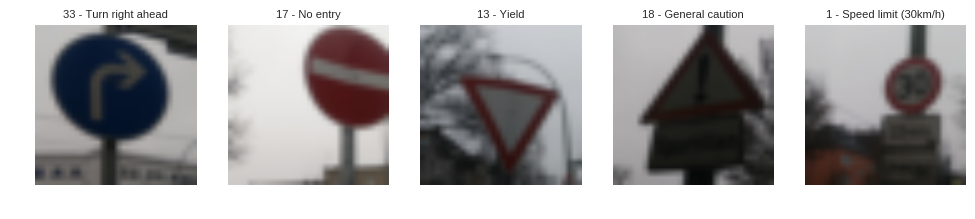

In [55]:
plot_signs(x_new, y_new, rows=1, cols=5, rnd=False)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The images were taken with a smartphone camera on a rainy day in Berlin, Germany. Since the training set also contains images of German traffic signs, the images are quite similar. There are mainly to difference between the train set and the candidate images. The size and the perspective.

The model expects the input images to be of size 32x32. To match the format the candidate images are center cropped and resized. The cropping is necessary since otherwise the actually traffic signs would be to small on the final images. As all the traffic signs are roughly in the center of the images, center cropping works well.

The difference in perspective is caused by the fact that the candidate images were taken from the sidewalk. Since the model was trained using augmented images, his should be a problem.

In [56]:
y_new, y_cls = one_hot_encoding(y_new, lb)
x_new = normalize(x_new)

In [57]:
with tf.Graph().as_default():
    with tf.name_scope("variables"):
        features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')
        labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
        labels_cls = tf.argmax(labels, dimension=1, name='labels_cls')
        is_training = tf.placeholder(tf.bool, [], name='is_training')
        keep_prop = tf.placeholder(dtype=tf.float32, name='keep_prop')
                                   
    logits = inference(features, keep_prop, is_training)
    softmax_prop = tf.nn.softmax(logits)
    accuracy = get_accuracy(logits, labels_cls)
    top_5 = tf.nn.top_k(softmax_prop, k=5, sorted=True)
    
    with tf.Session() as session:
        saver = tf.train.Saver(tf.all_variables())
        ckpt = tf.train.latest_checkpoint(TRAIN_DIR)
        saver.restore(session, ckpt)

        feed_dict={features: x_new,
                   labels: y_new,
                   keep_prop:1.,
                   is_training:False}
        softmax_prop, top_5, acc = session.run([softmax_prop, top_5, accuracy], feed_dict=feed_dict)
        
print('New Images Accuracy: %s' % acc)

New Images Accuracy: 0.8


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

The model performance well on newly acquired images as long as they have similar attributes. If the traffic sign is to small like in the example 5 or otherwise drastically distorted it won't work anymore.

In [58]:
import pandas as pd

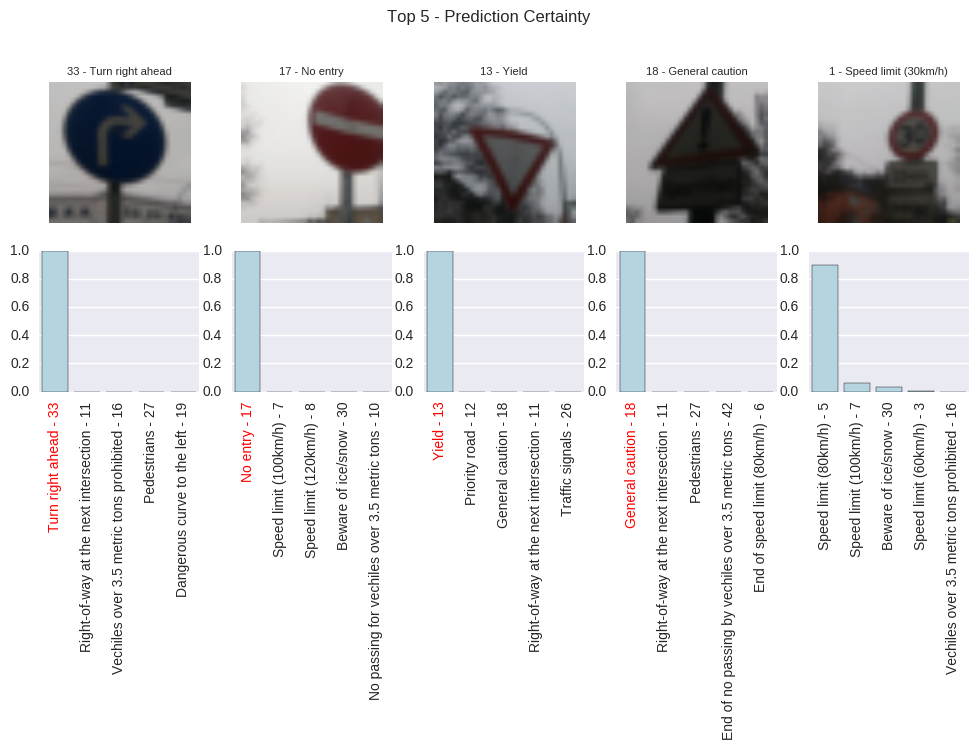

In [59]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
f.suptitle('Top 5 - Prediction Certainty', fontsize=12, y=1.08)

for i, ax in enumerate(axarr[0]):
    ax.imshow(x_new[i])
    ax.set_title('%s - %s' % (y_cls[i], signnames[y_cls[i]]), fontsize=8)
    ax.axis('off')

for i, ax in enumerate(axarr[1]):
    data = pd.DataFrame([top_5.values[i]])
    ax.set_ylim([0, 1.0])
    sns.barplot(data=data, ax=ax, color='lightblue', ci=None)
    
    _ = ax.set_xticklabels(['%s - %s'% (signnames[j], j) for j in top_5.indices[i]], rotation=90)
    
    [tick.set_color("red") for j, tick in enumerate(ax.get_xticklabels()) if top_5.indices[i][j] == y_cls[i]]

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The predictions for the candidate images are shown above. Each image is displayed with it's corresponding softmax probabilities (top 5) and it's true label. The correct label is also colored red in the probability chart. The model is always confident about it's prediction. The last image is incorrectly classified probability because the actual traffic sign is to small.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

After training the model was saved to disk using Tensorflows Saver object. This allows the model to be loaded anytime for additional training or in this case classification of newly acquired images. For that the images are loaded and transformed (cropped and resized) to match the input size of 32x32x3.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.